# KENYA AGRICULTURAL DOMESTIC SUPPLY PREDICTION

### Aim : Try and predict Kenya's domestic agricultural supply(crop/animal) for the next number of years

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from AgricSARIMA import AgricSARIMA
from Plotting import AgricPlots
from AgricVAR import AgricVAR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Enter the number of years you would like to predict

In [2]:
number_of_years_to_predict = int(input("Enter the number of years want to predict : "))
print(number_of_years_to_predict)

Enter the number of years want to predict : 7
7


### Generate the csv for Animal data and Crop data

In [4]:
%run PreparingCropAnimalData

## Load required datasets

In [5]:
animal_data_full = pd.read_csv("animal_data_redone.csv",index_col="Unnamed: 0",parse_dates=True)
crop_data_full = pd.read_csv("crop_data_redone.csv",index_col="Unnamed: 0",parse_dates=True)

## Visualizations

#### Columns which have values that might be equally large are plotted close together , for easier visibility
#### The values plotted together may not be very much related to each other, this is just to see general trends for each factor

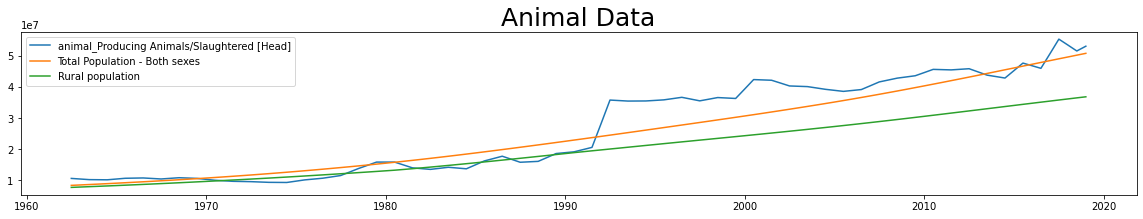

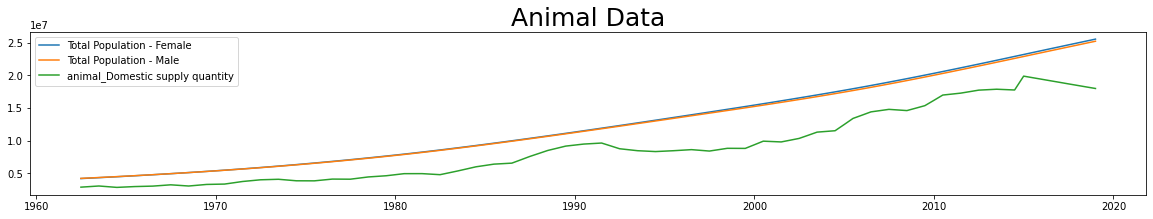

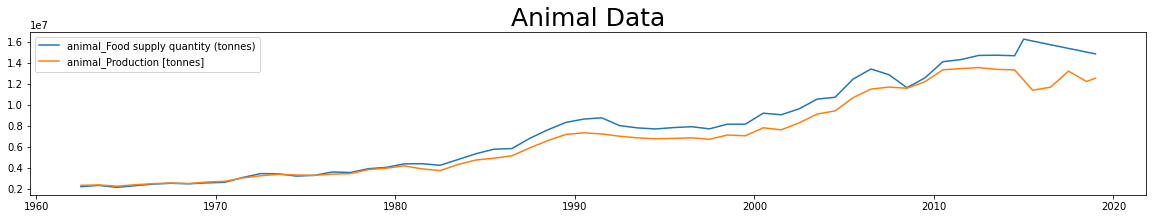

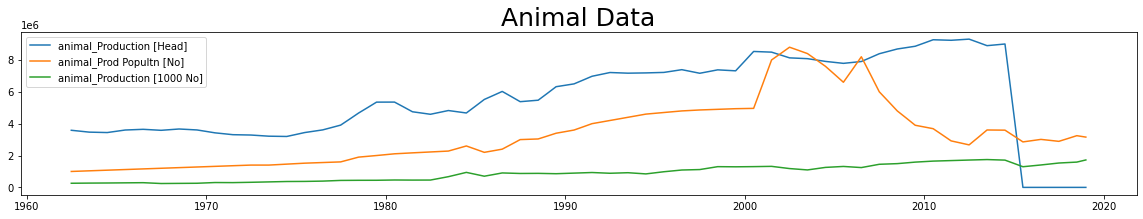

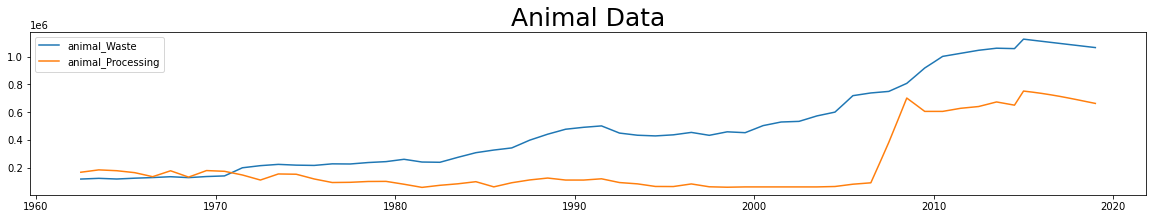

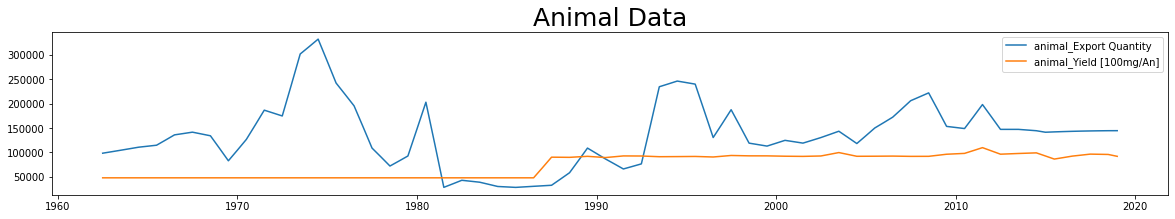

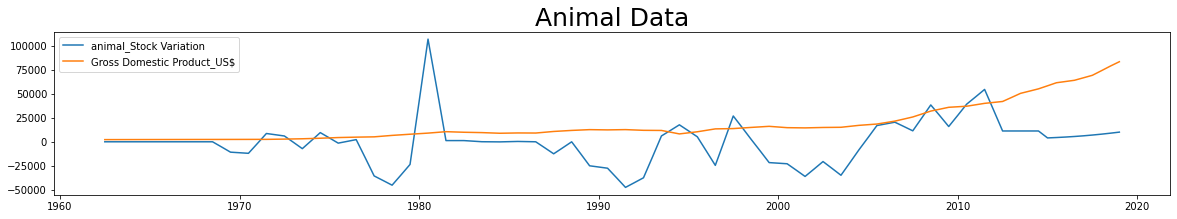

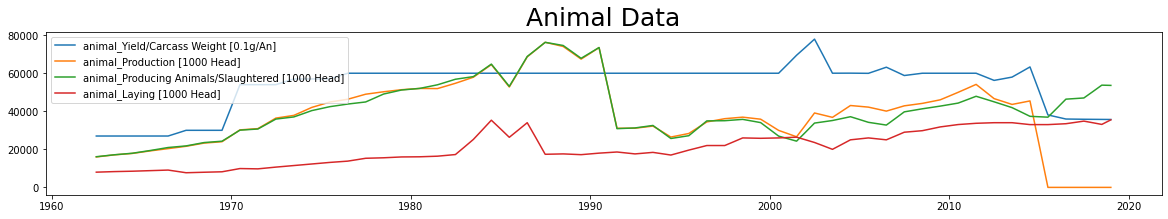

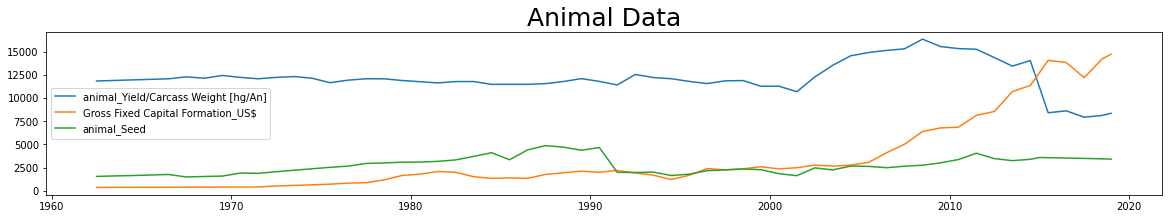

In [6]:
plt.rcParams["figure.figsize"]=(20,3)

animal_full_df_plot = AgricPlots(animal_data_full)
animal_full_df_plot.line_plotting("Animal Data")

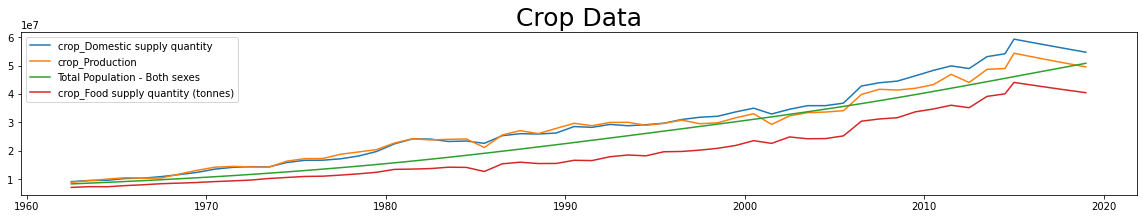

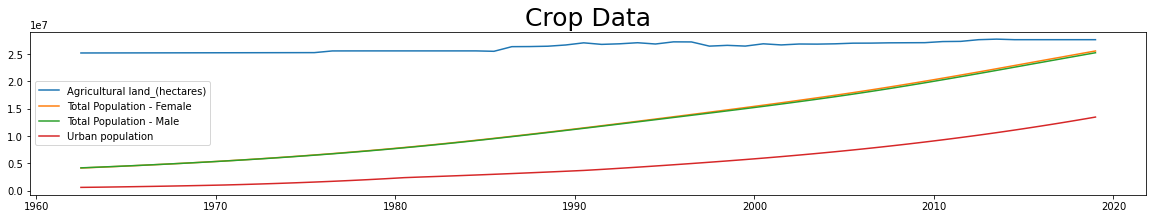

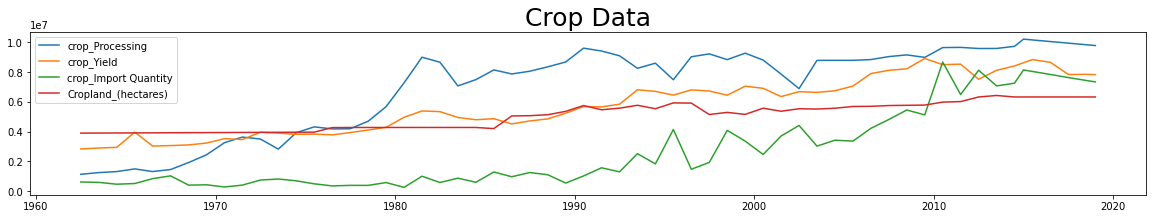

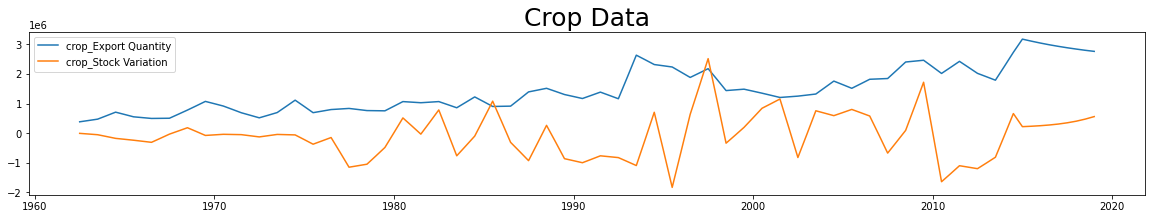

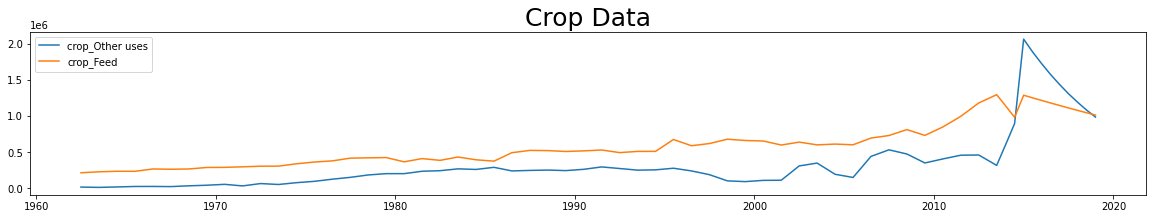

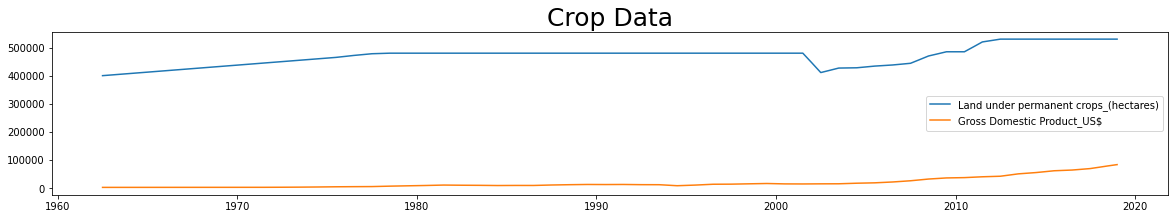

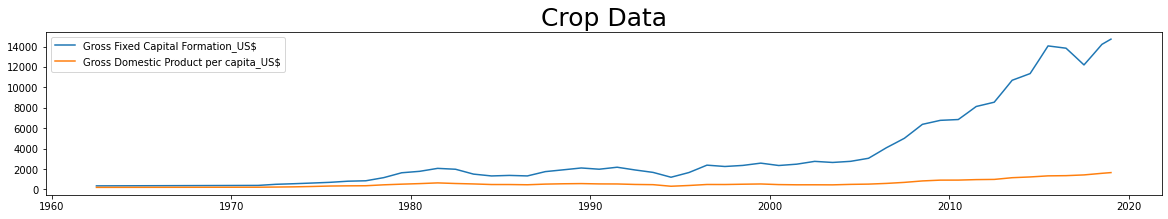

In [7]:
crop_full_df_plot = AgricPlots(crop_data_full)
crop_full_df_plot.line_plotting("Crop Data")

#### Since i'm trying to predict what dometic supply might/should be, I thought it best to take correlation of each factor to Domestic supply quantity

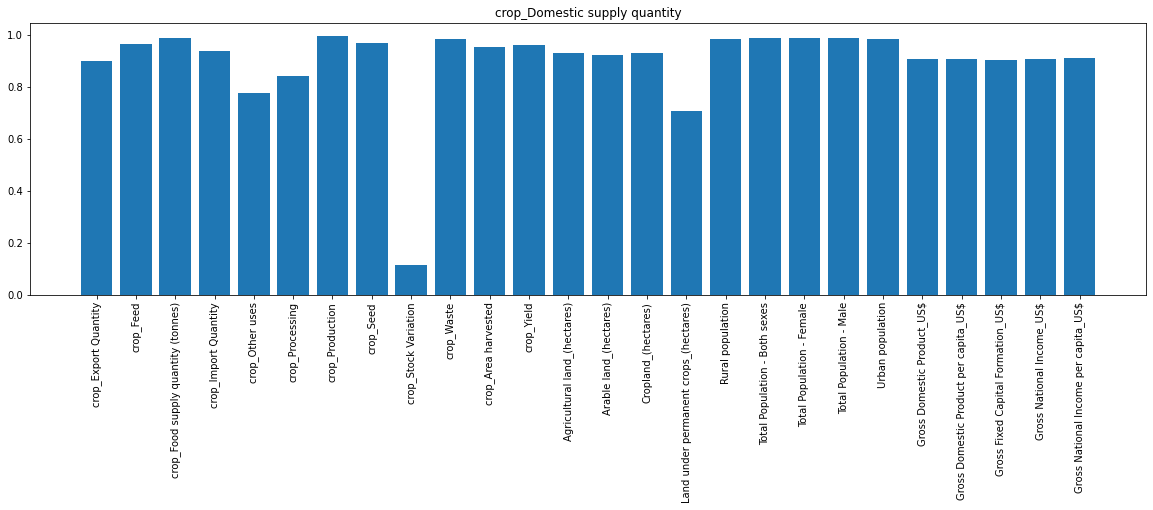

In [8]:
crop_full_df_plot.correlation_plot("crop_Domestic supply quantity")

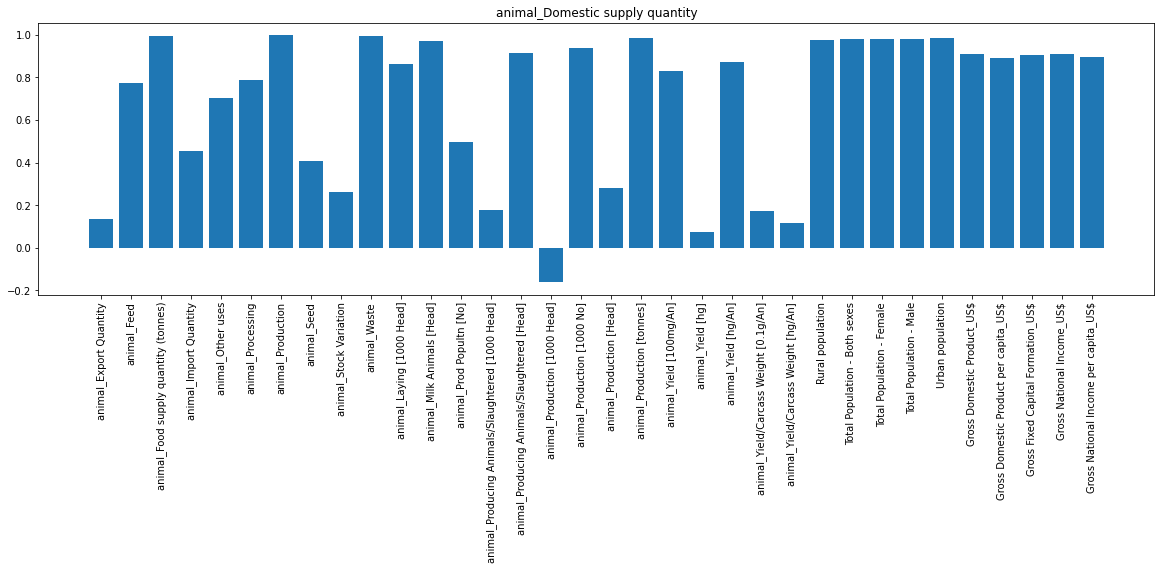

In [9]:
animal_full_df_plot.correlation_plot("animal_Domestic supply quantity")

### Regression plots

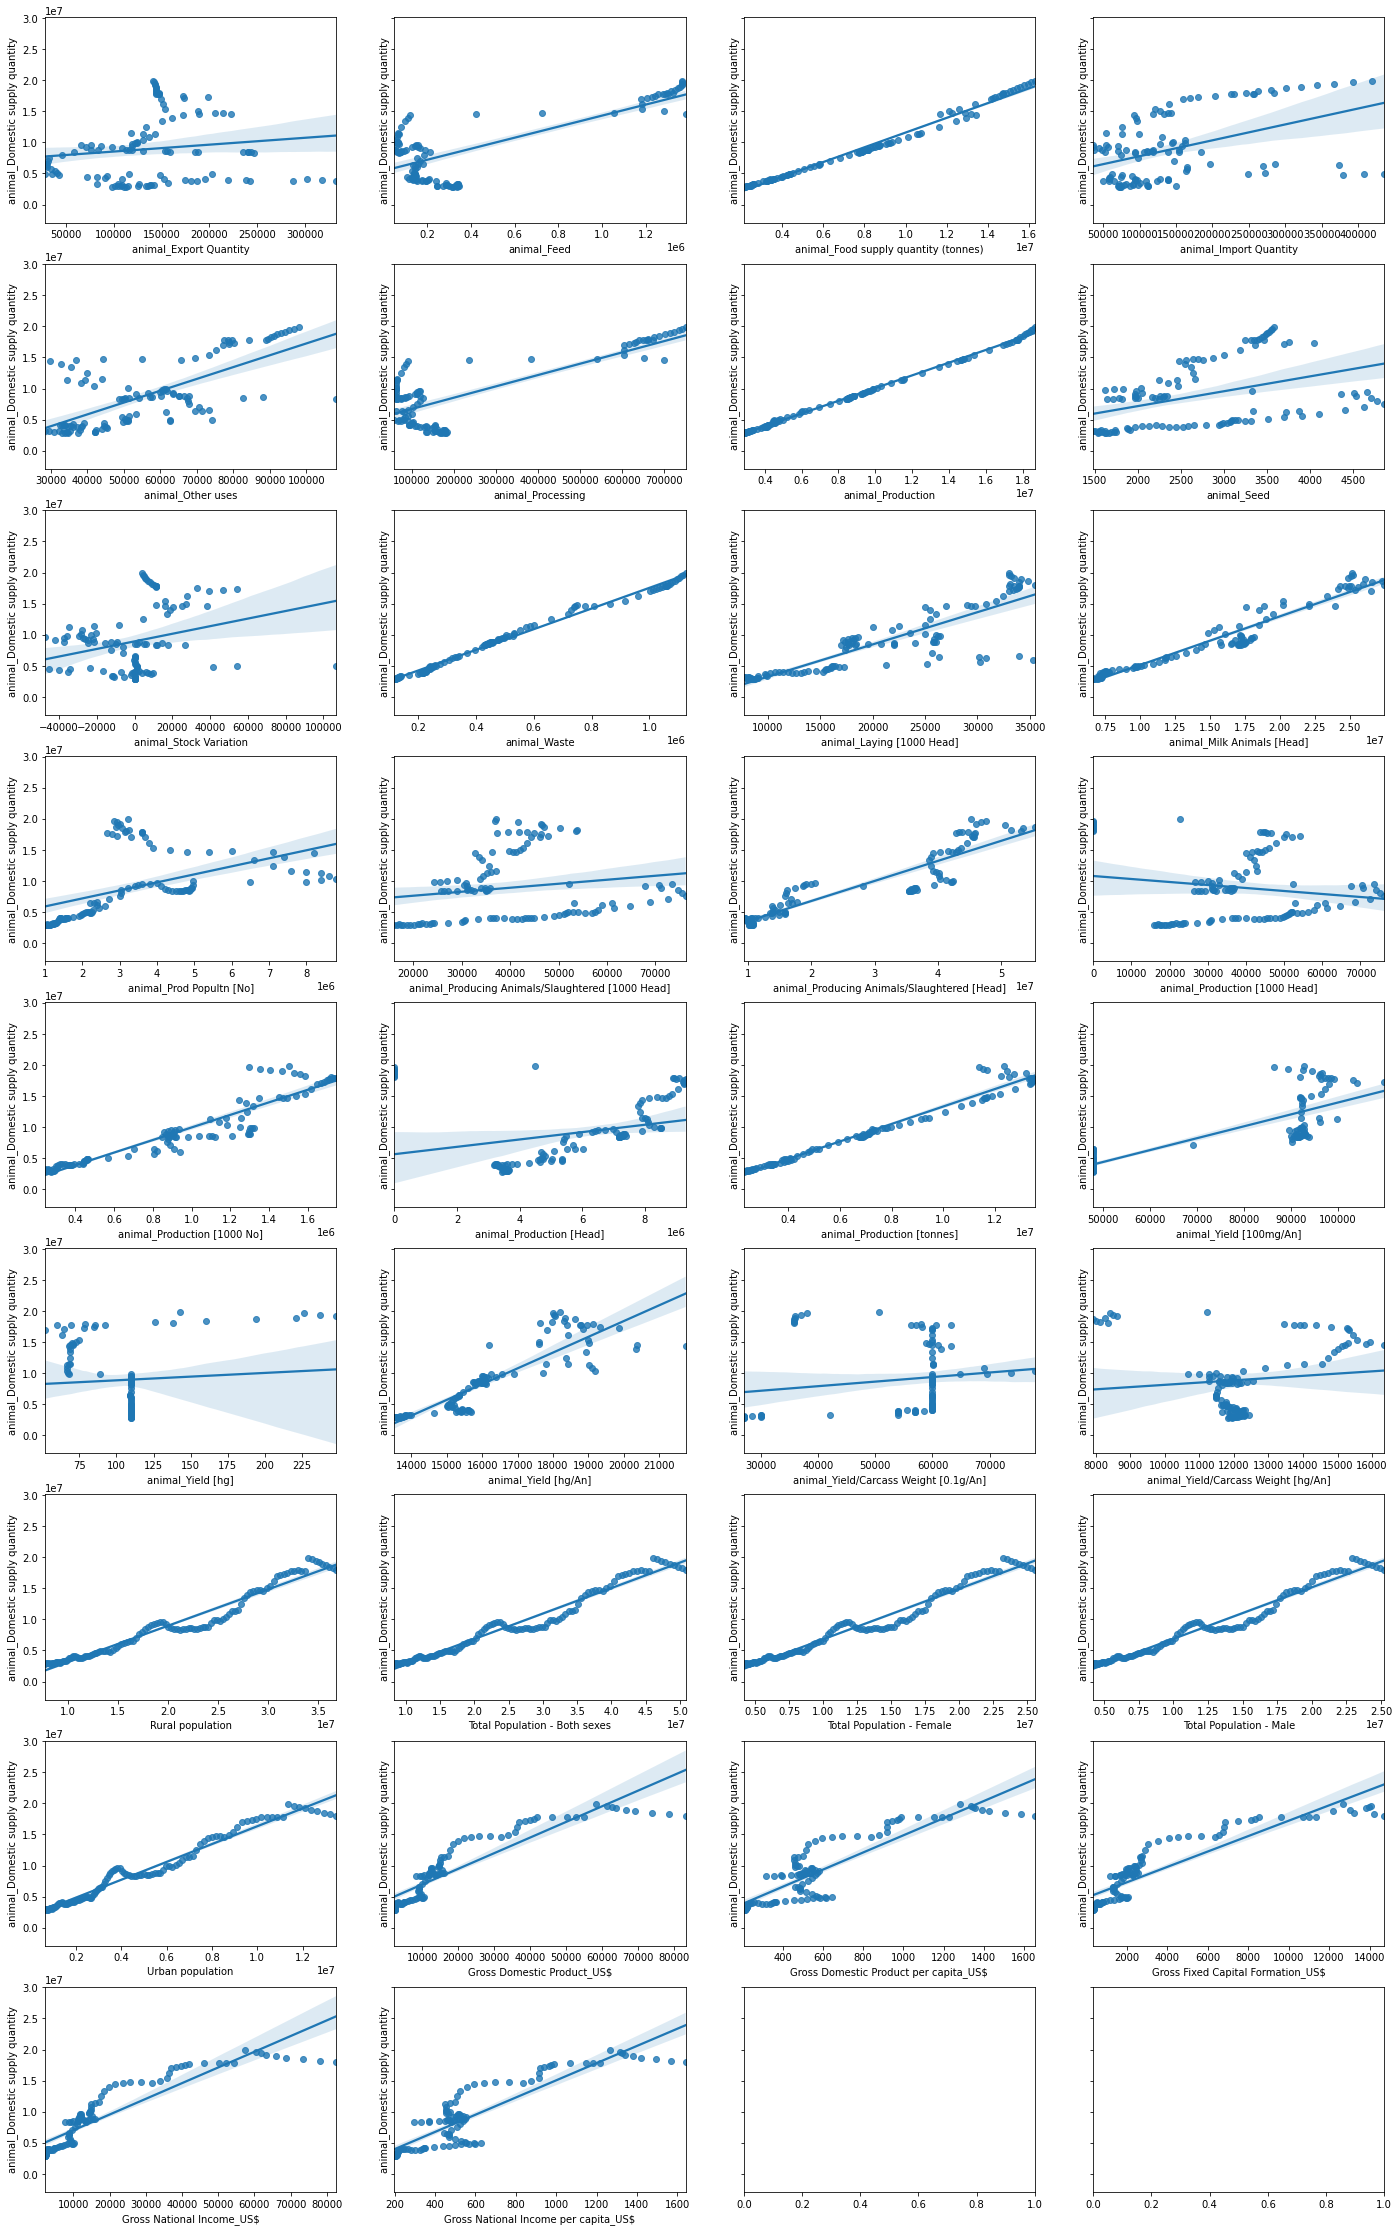

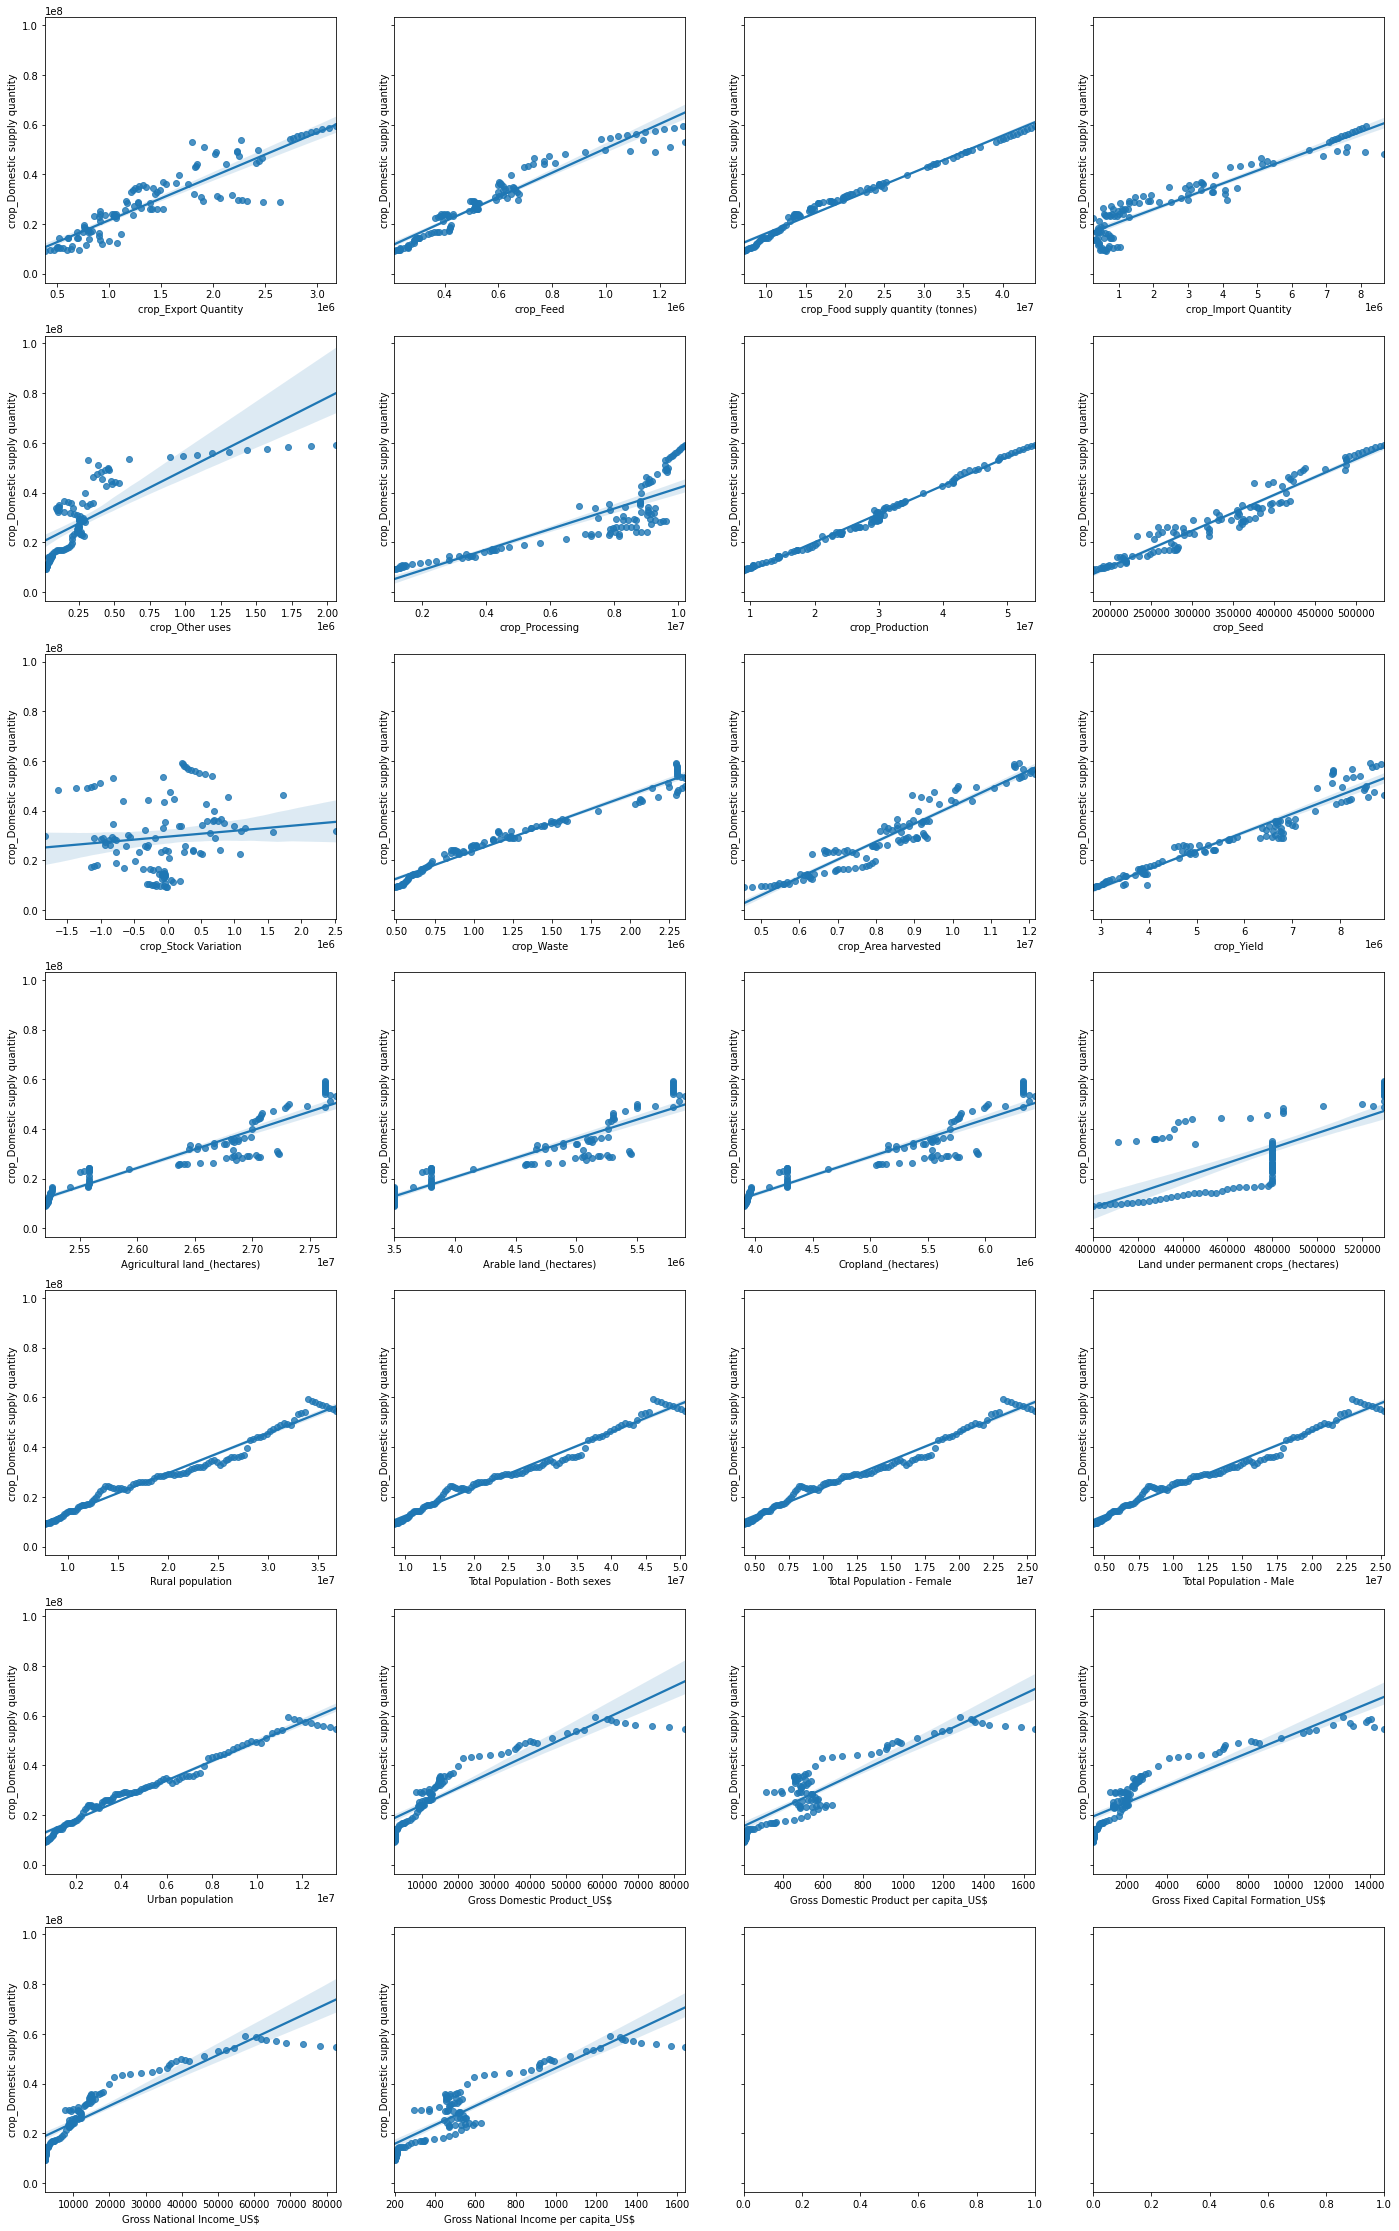

In [10]:
#see if it makes sense to regress, observing whether most values fit a regression plot
plt.rcParams['figure.figsize']=(24,40)
animal_full_df_plot.regression_plots("animal_Domestic supply quantity",4)   
crop_full_df_plot.regression_plots("crop_Domestic supply quantity",4)    

# 


# VAR MODEL

- Combine those with a causal effect on each other. Select those whose causality is close to each other.
- Those not able to fit into any combination are assigned a seperate list
- Use VAR on combined columns and SARIMAX on the non-compatible ones on  

### predicting with VAR

In [11]:
#Check for stationarity and Make the series stationary 
#Check for variance in residuals
def VAR_complete(dataframe, list_of_combinations):
    full_pred_df = pd.DataFrame()
    df_var = AgricVAR(dataframe, number_of_years_to_predict)
    for i in list_of_combinations: # loop through all combinations of columns generated 
        pred_df = df_var.var_prediction(i)
        full_pred_df = pd.concat([full_pred_df,pred_df],axis=1) # combine all predictions
    
    return full_pred_df

#### Convert the semi-annual back to annual

In [12]:
def semi_annual_pred_to_yearly(prediction_dataframe, number_of_years_to_predict):
    dataframe = prediction_dataframe.rolling(window = number_of_years_to_predict+1).mean().dropna()
    dataframe.index = prediction_dataframe.index.year.unique()
    
    return dataframe

#animal_prediction = semi_annual_pred_to_yearly(animal_prediction,number_of_years_to_predict )
#crop_prediction = semi_annual_pred_to_yearly(crop_prediction,number_of_years_to_predict )

# Regression to predict Domestic supply

In [13]:
def regression_function (df,target_column,prediction_df,y):
    cols_corr_to_target = df.columns [df.columns!=target_column]
    df_corr_data = abs(df.corr()[target_column][cols_corr_to_target])
    prediction_df_to_use= prediction_df[df_corr_data.index[df_corr_data>0.5]]
    
    train = df[prediction_df_to_use.columns]
    x_train = train / train.max()
    prediction_test = prediction_df_to_use/train.max()

    lasso_model = Lasso(alpha = 0.00001)
    lasso_model.fit(x_train , y)
    domestic_supply_pred= lasso_model.predict(prediction_test)
    domestic_supply_pred = domestic_supply_pred

    return domestic_supply_pred

### Animal  and Crop data behaved similar to each other with Lasso regression

## Combining everything into one function

In [14]:
def all_combined(df,target_column,number_of_years_to_predict):
    x = df[df.columns[df.columns!=target_column]]
    y = df[target_column]
    df_VAR = AgricVAR(x,number_of_years_to_predict)
    list_n = [[i] for i in x.columns]
    df_col_combinations, df_col_incompatible , granger_df = df_VAR.granger_causality(x.columns,5)
    # cointegration_test
    df_VAR.cointegration_test(df_col_combinations)
    x_var_prediction  = VAR_complete( x, df_col_combinations )
    pred_for_incompatible_cols = AgricSARIMA().sarima_compile(x, df_col_incompatible, number_of_years_to_predict)
    pred_for_incompatible_cols = pred_for_incompatible_cols.fillna(method='ffill')
    prediction = pd.concat([x_var_prediction,pred_for_incompatible_cols],axis=1)
    prediction_df = semi_annual_pred_to_yearly(prediction,number_of_years_to_predict )
    domestic_supply_pred = regression_function (df, target_column, prediction_df, y)
    prediction_df["predicted domestic supply"] = domestic_supply_pred

    return  prediction_df

In [15]:
animal_predicted_df = all_combined( animal_data_full,
                                    "animal_Domestic supply quantity",
                                    number_of_years_to_predict )
# animal_predicted_df

adf True
adf True


In [16]:
crop_predicted_df = all_combined( crop_data_full,
                                  "crop_Domestic supply quantity",
                                  number_of_years_to_predict )
#crop_predicted_df

adf True
adf True
adf True
adf True


In [17]:
#Load the predictions to CSVs
#crop_predicted_df.to_csv("crop supply fin.csv")
#animal_predicted_df.to_csv("animal supply fin.csv")

### Plot the Final Prediction to see the trend

In [18]:
crop_init = crop_data_full["crop_Domestic supply quantity"].resample('12M',convention="start",closed="left").asfreq()
animal_init = animal_data_full["animal_Domestic supply quantity"].resample('12M',convention="start",closed="left").asfreq()

animal_init.index = animal_init.index.year
crop_init.index = crop_init.index.year

animal_supply = pd.concat([animal_init,animal_predicted_df["predicted domestic supply"]])
crop_supply = pd.concat([crop_init,crop_predicted_df["predicted domestic supply"]])

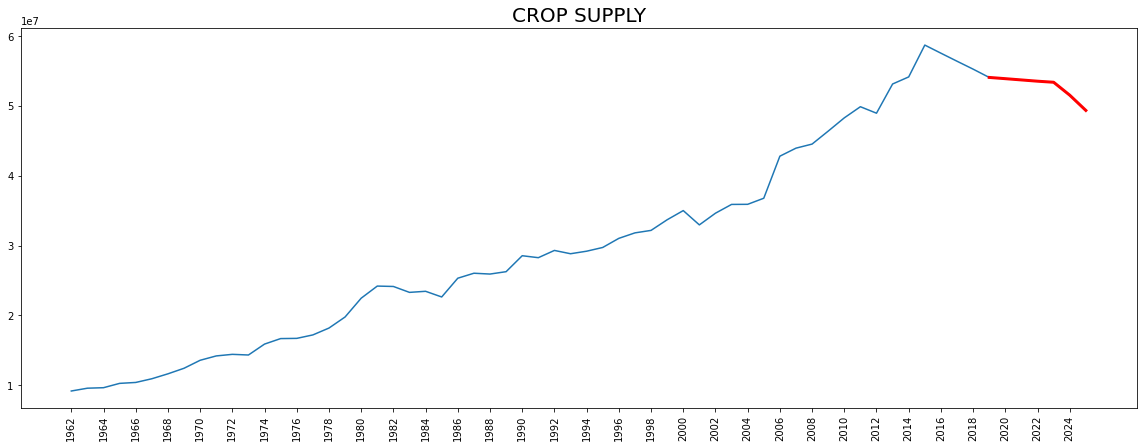

In [19]:
plt.figure(figsize = (20,7))
plt.title("CROP SUPPLY", fontsize=20)
plt.plot(crop_supply,)
plt.plot(crop_predicted_df["predicted domestic supply"],color="red",linewidth=3)
plt.xticks(np.arange(crop_supply.index[0],crop_supply.index[-1],2),rotation=90)
plt.show()

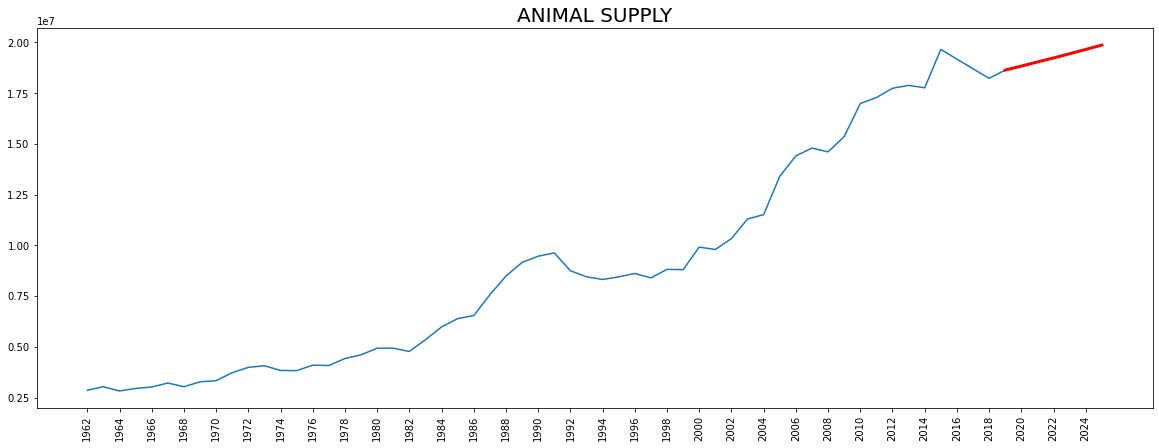

In [20]:
plt.figure(figsize = (20,7))
plt.title("ANIMAL SUPPLY",fontsize=20)
plt.plot(animal_supply)
plt.plot(animal_predicted_df["predicted domestic supply"],color="red",linewidth=3)
plt.xticks(np.arange(animal_supply.index[0],animal_supply.index[-1],2),rotation=90)
plt.show()